<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Demo 7.2.3: Stacking

INSTRUCTIONS:

- Run the cells
- Observe and understand the results

This is an excerpt from [Ensemble Methods](https://github.com/vsmolyakov/experiments_with_python/blob/master/chp01/ensemble_methods.ipynb) by **Vadim Smolyakov**.

## Stacking
**Stacking** is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

In [ ]:
## Import Libraries

import itertools
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import datasets

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import six
import sys
sys.modules['sklearn.externals.six'] = six

from sklearn.ensemble import StackingClassifier


In [ ]:
# Additional libraries and modules
from sklearn.metrics import make_scorer, zero_one_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

## Load data

In [ ]:
## Loading the dataset

iris = datasets.load_iris()

# picking just the first two features
X = iris.data[:, 1:3]
# target
y = iris.target


In [ ]:
## Check the data

# About data
print(X.shape)
print(X[:5])

(150, 2)
[[3.5 1.4]
 [3.  1.4]
 [3.2 1.3]
 [3.1 1.5]
 [3.6 1.4]]


In [ ]:
# About target
print(y.shape)
print(y[:5])

(150,)
[0 0 0 0 0]


## Modelling

In [ ]:
# Define the classifiers to compare
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(n_estimators=10, random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression(multi_class='auto', solver='lbfgs')
estimators = [('knn', clf1), ('rf', clf2), ('gnb', clf3)]
sclf = StackingClassifier(estimators=estimators, final_estimator=lr, cv=StratifiedKFold(n_splits=3))

## Presenting results

Note that the following code will not be needed in the labs. Decision boundaries can be shown when there are two features considered.

Accuracy: 0.91 (+/- 0.01) [K-NN]
Accuracy: 0.91 (+/- 0.02) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naïve Bayes]
Accuracy: 0.93 (+/- 0.03) [Stacking Classifier]


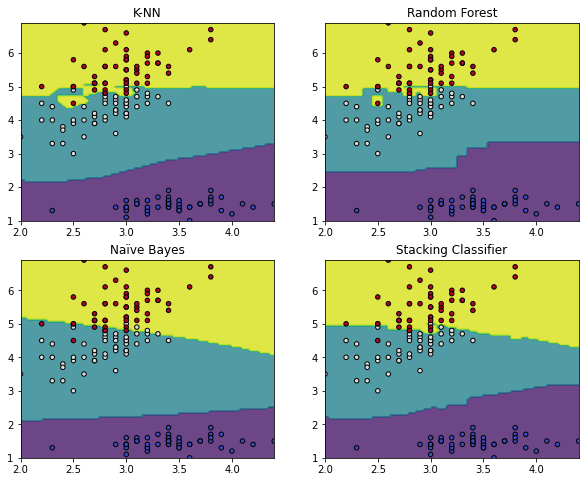

In [ ]:
label = ['K-NN', 'Random Forest', 'Naïve Bayes', 'Stacking Classifier']

# Create a figure and a grid of subplots
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0, 1], repeat=2)

# Initialize lists for mean and standard deviation of cross-validation scores
clf_cv_mean = []
clf_cv_std = []


# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=3)

for clf, label, grd in zip([clf1, clf2, clf3, sclf], label, grid):
    # Calculate cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

    # Fit the classifier on the entire dataset
    clf.fit(X, y)

    # Create a meshgrid to plot decision regions
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                         np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision regions using contourf
    ax = plt.subplot(gs[grd[0], grd[1]])
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_title(label)

plt.show()


The stacking ensemble is illustrated int the figure above. It consists of k-NN, Random Forest and Naive Bayes base classifiers whose predictions are combined by Logistic Regression as a meta-classifier. We can see the blending of decision boundaries achieved by the stacking classifier.

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

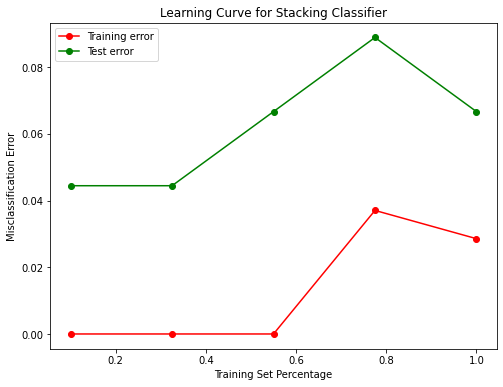

In [ ]:
# SkLearn version of plot learning curves using Stacking Classifier
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8, 6))

# Define the scoring function (misclassification error)
scorer = make_scorer(zero_one_loss, greater_is_better=False)

# Initialize lists to store training and test errors
train_errors = []
test_errors = []

# Vary the training set size and calculate errors
for size in np.linspace(0.1, 1.0, 5):
    size = int(size * len(X_train))
    X_subset, y_subset = X_train[:size], y_train[:size]

    # Fit the stacking classifier on the training subset
    sclf.fit(X_subset, y_subset)

    # Calculate predictions for training and test sets
    train_pred = sclf.predict(X_subset)
    test_pred = sclf.predict(X_test)

    # Calculate training error
    train_errors.append(zero_one_loss(y_subset, train_pred))

    # Calculate test error
    test_error = zero_one_loss(y_test, test_pred)
    test_errors.append(test_error)

# Plot the learning curve
ax.plot(np.linspace(0.1, 1.0, 5), train_errors, "o-", color="r", label="Training error")
ax.plot(np.linspace(0.1, 1.0, 5), test_errors, "o-", color="g", label="Test error")

# Set the title and the legend of the subplot
ax.set_title(f"Learning Curve for Stacking Classifier")
ax.set_xlabel("Training Set Percentage")
ax.set_ylabel("Misclassification Error")
ax.legend(loc="best")

# Show the plot
plt.show()


We can see that stacking achieves higher accuracy than individual classifiers and based on learning curves, it shows no signs of overfitting.

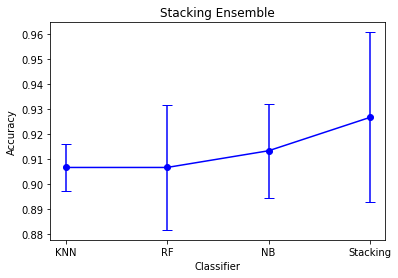

In [ ]:
# plot classifier accuracy
plt.figure()
(_, caps, _) = plt.errorbar(
    range(4),
    clf_cv_mean,
    yerr = clf_cv_std,
    c = 'blue',
    fmt = '-o',
    capsize = 5)

for cap in caps:
    cap.set_markeredgewidth(1)

plt.title('Stacking Ensemble')
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.xticks(range(4), ['KNN', 'RF', 'NB', 'Stacking'])
plt.show()



---



---



> > > > > > > > > © 2024 Institute of Data


---



---



